# TEAM NAME ETC

# Overview

Our task is to build an inferential linear regression model. Our model will help Opendoor make more accurate offers in accordance with their valuation process. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

# Business Understanding

Our stakeholder is Opendoor. Opendoor makes cash offers for homes and resells them. They perform repairs on the home if necessary. They also offer a listing service. They make their profits from fees, not from buying low and selling high. We will be assisting this company in the King County, Washington area. The county seat is Seattle.

The Opendoor process begins with evaluations of a home through photos, listed upgrades, and listed amenities. Next, they find comparable homes or 'comps' to provide a base range. Next, they make adjustments to the offer based on differences between comps. These differences can include features or neighborhood trends. Lastly, they make an offer and send someone to inspect the home.

Our job is to analyze the King County data set and provide solid valuation models that can assist with finding comp valuations, and then detailing the needed adjustments. Different markets have slight differences, and we will report on the most important parameters when assessing home values in the King County area. Since they also do repairs, we will also look at factors that assess the condition and amount of repairs likely needed in the property. Opendoor will be able to use our recommendations to make fair offers in the King County area.

# Data Understanding

The data that we used is King County House Sales data from the King County assessor website. Our data set includes info about homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside the realm of what our stakeholder purchases. This included homes with a price over $1,400,000, homes built before 1930, and homes with a lot size above 2 acres (87,120 square feet).

## *Loading our data*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Keep price < 1400000
df = df[df['price']<=1400000]
#Keep yr built above 1930
df = df[df['yr_built']>1930]
#Delete bedroom >15 typo
df.drop(df[df['bedrooms']>15].index, inplace=True)
#Keep lots under 2 acres or 87120 sqft
df = df[df['sqft_lot']<=87120]

In [5]:
df.shape

(17867, 21)

## Column formatting & Dealing with missing values

### *Renovated < 10 yrs*

In [6]:
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['renovated_less_10yrs'] = df['yr_renovated'] > 2010.0
df['renovated_less_10yrs'] = df['renovated_less_10yrs'].astype('int64')

### *Condition Column*

In [7]:
df['condition'].replace('Poor', '1', inplace=True)
df['condition'].replace('Fair', '2', inplace=True)
df['condition'].replace('Average', '3', inplace=True)
df['condition'].replace('Good', '4', inplace=True)
df['condition'].replace('Very Good', '5', inplace=True)
df['condition'] = df['condition'].astype(np.int64)

### *View Column*

In [8]:
df['view'].fillna('NONE', inplace=True)
df['view'].replace('NONE', '0', inplace=True)
df['view'].replace('FAIR', '1', inplace=True)
df['view'].replace('AVERAGE', '2', inplace=True)
df['view'].replace('GOOD', '3', inplace=True)
df['view'].replace('EXCELLENT', '4', inplace=True)
df['view'] = df['view'].astype(np.int64)

### *Sqft Basement Column*

In [9]:
df['sqft_basement'].replace(to_replace='?', value='0', inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'],errors='coerce')
df['has_basement'] = df['sqft_basement']
df.loc[df.has_basement > 0, 'has_basement'] = 1

### *Date Column*

In [10]:
# Converting to Datetime
df['date'] =  pd.to_datetime(df['date'], format='%m/%d/%Y')

### *Waterfront Column*

In [11]:
# Converting Waterfront to Binary
df['waterfront'] = df['waterfront'].fillna('0')
df['waterfront'].replace(to_replace='NO', value='0', inplace=True)
df['waterfront'].replace(to_replace='YES', value='1', inplace=True)
df['waterfront'] = pd.to_numeric(df['waterfront'],errors='coerce')

### *Grade Column*

In [12]:
# Converting Grade to Numeric
df['grade'] = df['grade'].str.slice(0,2).str.strip()
df['grade'] = df['grade'].astype(np.int64)

In [13]:
# shape and data types of the data
print(df.shape)
print(df.dtypes)

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(17867, 23)
id                               int64
date                    datetime64[ns]
price                          float64
bedrooms                         int64
bathrooms                      float64
sqft_living                      int64
sqft_lot                         int64
floors                         float64
waterfront                       int64
view                             int64
condition                        int64
grade                            int64
sqft_above                       int64
sqft_basement                  float64
yr_built                         int64
yr_renovated                   float64
zipcode                          int64
lat                            float64
long                           float64
sqft_living15                    int64
sqft_lot15                       int64
renovated_less_10yrs             int64
has_basement                   float64
dtype: object
['id' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'wate

# Modeling

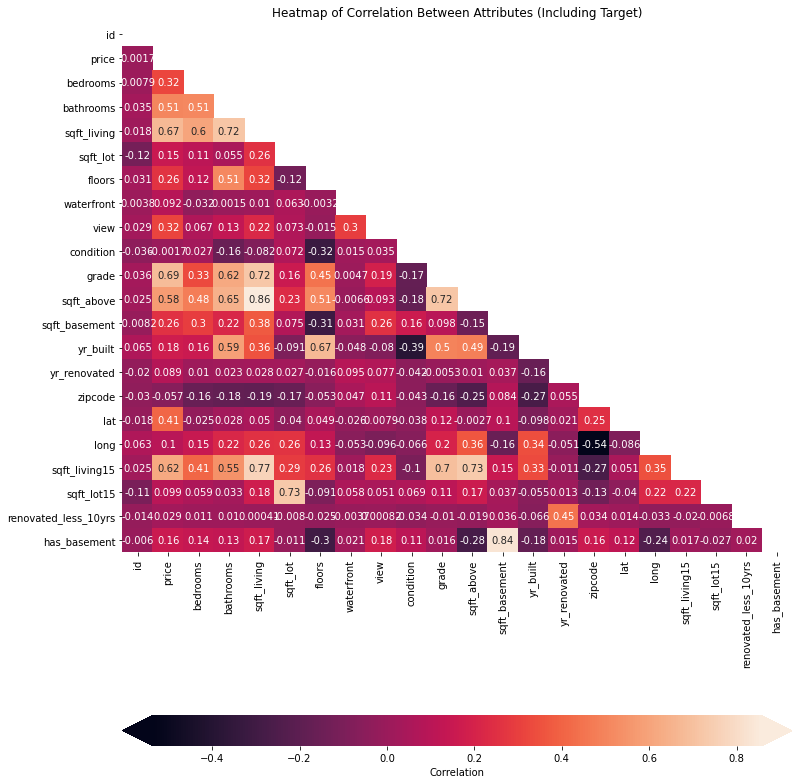

In [14]:
# heatmap_data = pd.concat([y_train, X_train], axis=1)
# corr = heatmap_data.corr()
corr = df.corr()
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 15))
# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

## Baseline Model

In [15]:
#create mean_price col
df['mean_price'] = df['price'].mean()
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated_less_10yrs',
       'has_basement', 'mean_price'],
      dtype='object')

In [16]:
baseline_y = df['price'].mean()
baseline_x = df.drop('price', axis=1)

In [17]:
baseline_y = df['price']
baseline_x = df['mean_price']
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_x, baseline_y, random_state=42)

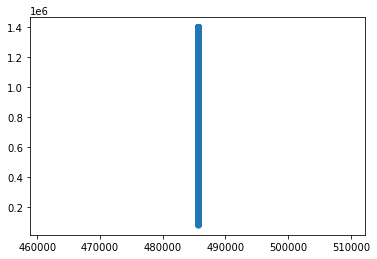

In [18]:
fig, ax = plt.subplots()
ax.scatter(baseline_X_train, baseline_y_train, alpha=0.5);

In [19]:
#OLS chart
baseline_formula = 'baseline_y ~ baseline_x'
baseline_model = ols(baseline_formula, df).fit()
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             baseline_y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 05 Oct 2021   Prob (F-statistic):                nan
Time:                        01:32:09   Log-Likelihood:            -2.4649e+05
No. Observations:               17867   AIC:                         4.930e+05
Df Residuals:                   17866   BIC:                         4.930e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.06e-06   7.53e-09    273.491      0.000    2.04e-06    2.07e-06
baseline_x     1.0000      0.004    273.491      0.000       0.993       1.007
==============================================================================
Omnibus:                     3396.081   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6073.609
Skew:                           1.214   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                     5.79e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.26e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
#dropping mean_price col after baseline done
df = df.drop('mean_price', axis=1)

## First Model: Square Feet Living & Price

In [21]:
y = df["price"]
X = df.drop("price", axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

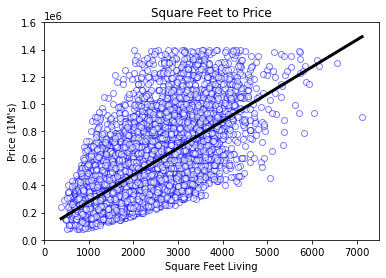

In [23]:
most_correlated_feature = X_train['sqft_living']
fig, ax = plt.subplots()
ax.scatter(most_correlated_feature, y_train, alpha=0.5, color ='white', edgecolor='blue')
ax.set_xlabel('Square Feet Living')
ax.set_ylabel("Price (1M's)")
ax.set_title('Square Feet to Price')
ax.set_xlim([0, 7500])
ax.set_ylim([0, 1600000])
plt.plot(np.unique(most_correlated_feature), np.poly1d(np.polyfit(most_correlated_feature, y_train, 1))
         (np.unique(most_correlated_feature)),linewidth=3.0,color='black');

In [24]:
first_formula = 'price ~ sqft_living'
first_model = ols(first_formula, df).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                 1.488e+04
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        01:32:09   Log-Likelihood:            -2.4108e+05
No. Observations:               17867   AIC:                         4.822e+05
Df Residuals:                   17865   BIC:                         4.822e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.226e+04   3556.507     23.131      0.000    7.53e+04    8.92e+04
sqft_living   197.2792      1.617    121.991      0.000     194.109     200.449
==============================================================================
Omnibus:                     2377.288   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4429.685
Skew:                           0.860   Prob(JB):                         0.00
Kurtosis:                       4.731   Cond. No.                     5.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

# first_model_scores = cross_validate(
#     estimator=first_model,
#     X=X_train[['sqft_living']],
#     y=y_train,
#     return_train_score=True,
#     cv=splitter
# )

# print("Train score:     ", first_model_scores["train_score"].mean())
# print("Validation score:", first_model_scores["test_score"].mean())

## Second Model

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
second_formula = 'price ~ sqft_living + grade + condition + view + sqft_lot + sqft_living15'
second_model = ols(second_formula, df).fit()
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     4073.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        01:33:05   Log-Likelihood:            -2.3879e+05
No. Observations:               17867   AIC:                         4.776e+05
Df Residuals:                   17860   BIC:                         4.777e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.763e+05   1.26e+04    -45.631      0.000   -6.01e+05   -5.52e+05
sqft_living      82.1174      2.446     33.572      0.000      77.323      86.912
grade          8.887e+04   1682.779     52.809      0.000    8.56e+04    9.22e+04
condition      3.884e+04   1937.963     20.040      0.000     3.5e+04    4.26e+04
view           5.421e+04   1779.807     30.460      0.000    5.07e+04    5.77e+04
sqft_lot         -0.7214      0.114     -6.332      0.000      -0.945      -0.498
sqft_living15    40.6632      2.959     13.740      0.000      34.862      46.464
==============================================================================
Omnibus:                     2188.221   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4414.195
Skew:                           0.774   Prob(JB):                         0.00
Kurtosis:                       4.880   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

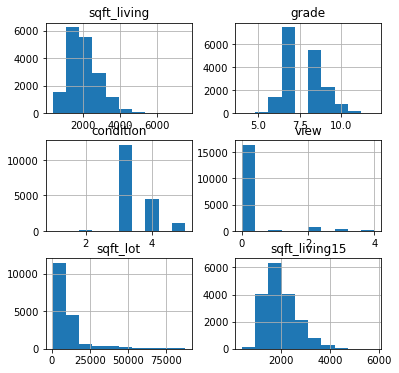

In [39]:
df[['sqft_living', 'grade', 'condition', 'view', 'sqft_lot', 'sqft_living15']].hist(figsize  = [6, 6]); 

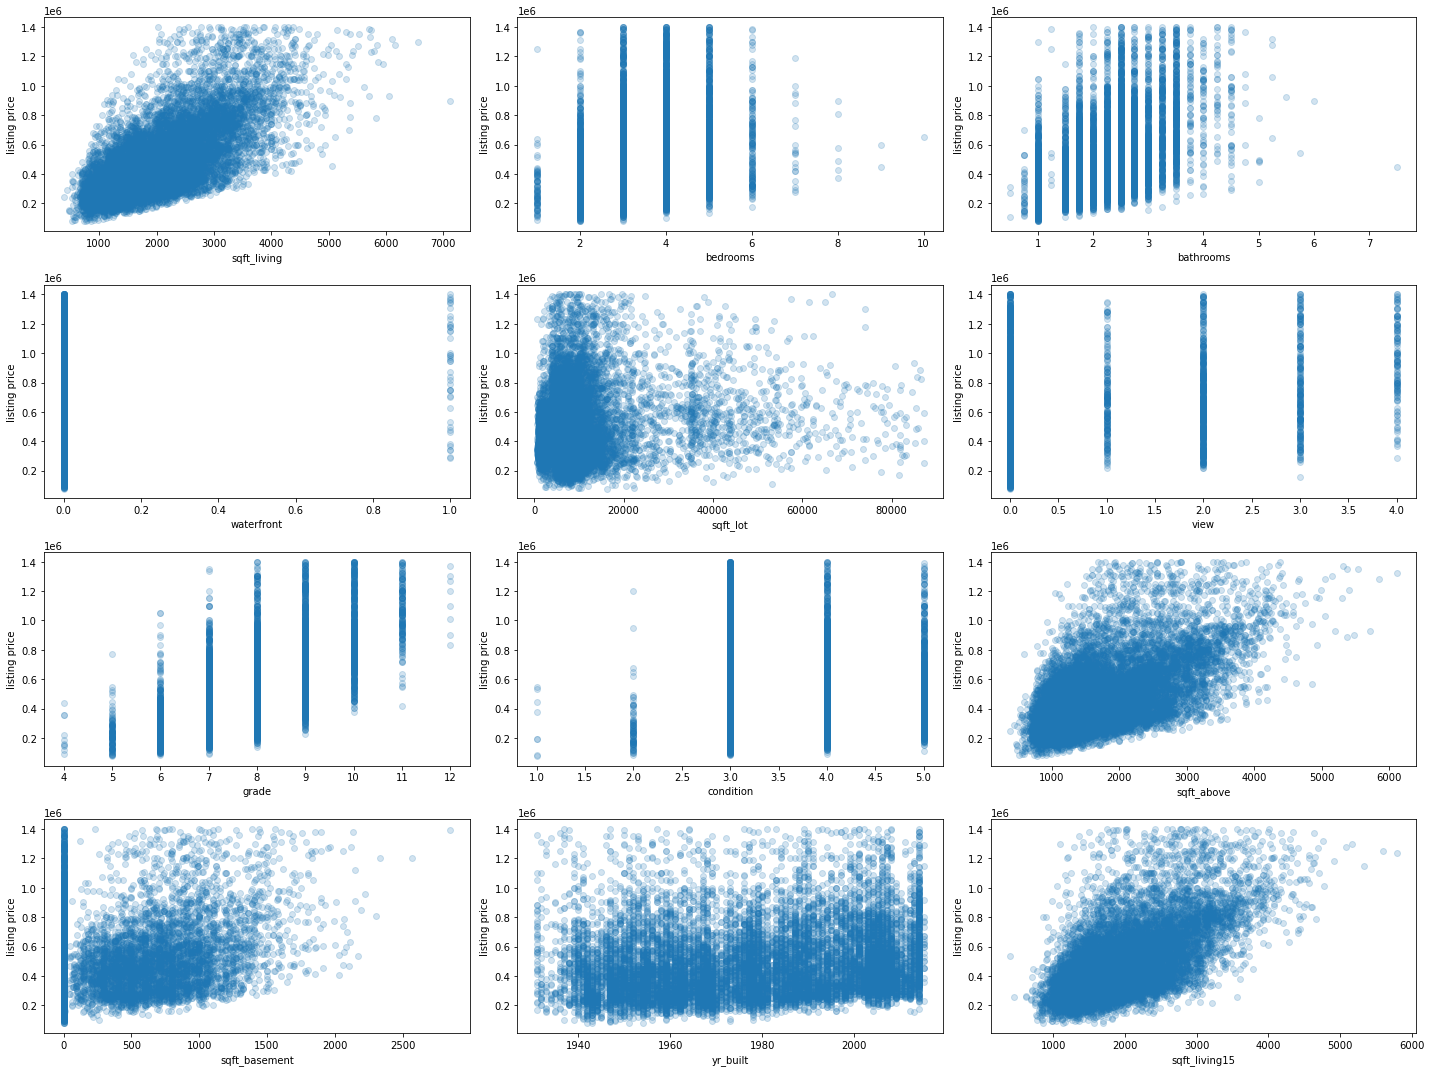

In [29]:
X_train_numeric = X_train.select_dtypes("number").copy()
relevant_cols_3 = ['sqft_living', 'bedrooms', 'bathrooms', 'waterfront', 'sqft_lot', 'view', 'grade', 'condition', 'sqft_above',
'sqft_basement', 'yr_built', 'sqft_living15']
X_train_numeric = X_train_numeric[relevant_cols_3]
scatterplot_data = X_train_numeric

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 15))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train_numeric[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

In [46]:
X_train_numeric

,sqft_living,bedrooms,bathrooms,waterfront,sqft_lot,view,grade,condition,sqft_above,sqft_basement,yr_built,sqft_living15
16597,2170,4,3.00,0,2500,0,8,3,1710,460.0,1997,2170
3869,1200,4,1.75,0,7680,0,7,3,1200,0.0,1968,1490
15805,1040,3,1.00,0,7500,0,6,4,1040,0.0,1954,1270
16471,920,2,1.00,0,8341,0,7,3,920,0.0,1939,2330
15350,1570,3,1.00,0,9136,0,7,3,1570,0.0,1953,1380
...,...,...,...,...,...,...,...,...,...,...,...,...
13814,2350,4,2.50,0,10655,0,8,3,2350,0.0,1992,2210
14692,2800,6,2.00,0,29985,0,7,5,1400,0.0,1954,1980
6634,1540,3,1.00,0,9800,0,7,4,1540,0.0,1950,1560
1039,1600,2,1.00,0,8961,0,7,4,1390,210.0,1949,1502


In [30]:
model_3 = ['sqft_living', 'grade', 'view', 'condition', 'sqft_living15', 'sqft_lot']
X_train_second_model = X_train_numeric[model_3]
# X_train_second_model

In [40]:
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
# print("Baseline Model")
# print("Train score:     ", first_model_scores["train_score"].mean())
# print("Validation score:", first_model_scores["test_score"].mean())

Current Model
Train score:      0.5744888740481637
Validation score: 0.5772568246184455



In [41]:
import statsmodels.api as sm

sm.OLS(y_train, sm.add_constant(X_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     3025.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        01:33:37   Log-Likelihood:            -1.7918e+05
No. Observations:               13400   AIC:                         3.584e+05
Df Residuals:                   13393   BIC:                         3.584e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.804e+05   1.47e+04    -39.488      0.000   -6.09e+05   -5.52e+05
sqft_living      84.3428      2.841     29.689      0.000      78.774      89.911
grade          9.004e+04   1952.425     46.117      0.000    8.62e+04    9.39e+04
view           5.576e+04   2059.322     27.076      0.000    5.17e+04    5.98e+04
condition      3.835e+04   2242.173     17.106      0.000     3.4e+04    4.27e+04
sqft_living15    36.2649      3.430     10.574      0.000      29.542      42.987
sqft_lot         -0.6153      0.132     -4.672      0.000      -0.873      -0.357
==============================================================================
Omnibus:                     1591.724   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3125.988
Skew:                           0.762   Prob(JB):                         0.00
Kurtosis:                       4.809   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
#cond no is large so there is multicollinearity

In [34]:
# significant_features = ["sqft_living", "grade", 'condition', 'view']
# third_model = LinearRegression()
# X_train_third_model = X_train[significant_features]

# third_model_scores = cross_validate(
#     estimator=third_model,
#     X=X_train_third_model,
#     y=y_train,
#     return_train_score=True,
#     cv=splitter
# )

# print("Current Model")
# print("Train score:     ", third_model_scores["train_score"].mean())
# print("Validation score:", third_model_scores["test_score"].mean())
# print()
# print("Second Model")
# print("Train score:     ", second_model_scores["train_score"].mean())
# print("Validation score:", second_model_scores["test_score"].mean())
# print()

In [35]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
sqft_living: True
grade: True
view: True
condition: True
sqft_living15: True
sqft_lot: True


In [47]:
X_test_second_model = X_test[model_3]

In [49]:
second_model = LinearRegression()

# Fit the model on X_train_final and y_train
second_model.fit(X_train_second_model, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
second_model.score(X_test_second_model, y_test)

0.5841951370131935

In [50]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, second_model.predict(X_test_second_model), squared=False)

151233.12737857646

### *Interpreting the model*

In [51]:
print(pd.Series(second_model.coef_, index=X_train_second_model.columns, name="Coefficients"))
print()
print("Intercept:", second_model.intercept_)

sqft_living         84.342786
grade            90039.950260
view             55757.427545
condition        38353.580007
sqft_living15       36.264902
sqft_lot            -0.615314
Name: Coefficients, dtype: float64

Intercept: -580396.571588502


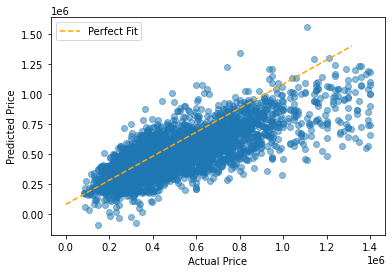

In [52]:
#LINEARITY
preds = second_model.predict(X_test_second_model)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

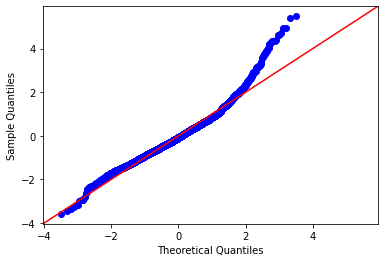

In [53]:
#NORMALITY
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [57]:
#MULTICOLLINEARITY (NEEDS TO BE <5 ALL CATEGORIES)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train_second_model.values, i) for i in range(X_train_second_model.shape[1])]
pd.Series(vif, index=X_train_second_model.columns, name="Variance Inflation Factor")

sqft_living      19.882531
grade            48.081534
view              1.135292
condition        18.787133
sqft_living15    28.290740
sqft_lot          2.179716
Name: Variance Inflation Factor, dtype: float64

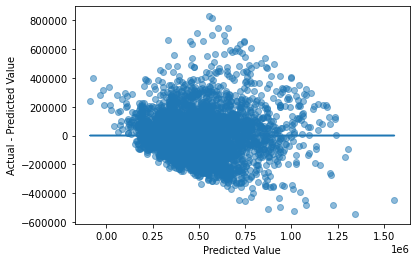

In [56]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## All variables except id and date

In [ ]:
X_train.info()

In [ ]:
df1 = df.drop('date', axis=1)
df1 = df1.drop('id', axis=1)
y = df1["price"]
X = df1.drop("price", axis=1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X_train.info()

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
cross_val_score(model, X_train, y_train, cv=3)

In [ ]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

# Regression Results

# Conclusion